<a href="https://colab.research.google.com/github/Shazizan/portfolio/blob/master/assessment_paynet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Summary:

Setup PySpark in Google Colab

Start a Spark Session

Upload Dataset

Read the Dataset with PySpark

Understand the Data

Data Cleaning & Transformation
 - handling missing value

Handle PII Data
 - masked the PII column
 - drop the original PII column
 - check the count for customer without exposing the PII data

Flatten the data (conduct the inspection whether if needed)

Data Visualisation
 - Total Transaction Amount by Income Category
 - Number of Customer by Income Category

##Setup PySpark in Google Colab

Since Google Colab doesn't have PySpark pre-installed, so first, I need to install and configure it.

In [49]:
# Install Java and Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.digitalpacific.com.au/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()

##Start a Spark Session

This will let me use Pyspark in Colab

In [50]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

##Upload Dataset

Upload the dataset that I've chosen from the Kaggle

In [51]:
from google.colab import files

uploaded = files.upload()

Saving BankChurners.csv to BankChurners (1).csv


##Read the Dataset with PySpark

In [52]:
file_name = list(uploaded.keys())[0]

df = spark.read.csv(file_name, header=True, inferSchema=True)
df.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

##Understand the Data

Here is to get schema and count to understand columns and data types.
We could see that the structure of our column (no nested column)

In [53]:
df.printSchema()
print(f"Number of rows: {df.count()}")

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

##Data Cleaning & Transformation

Handling missing value

In [54]:
from pyspark.sql.functions import col

# Count nulls per column
df.select([
    (col(c).isNull().cast("int")).alias(c) for c in df.columns
]).show(5)

+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrition_Fl

Fill the null value

-It fills null or missing values in the column Income_Category with the string "Unknown".

-It also fills missing values in Marital_Status with "Unknown".

-Other columns stay as-is (missing values remain untouched)

In [55]:
df_clean = df.na.fill({"Income_Category": "Unknown", "Marital_Status": "Unknown"})

In [56]:
df_clean.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

##Handle PII Data

This will:

Convert CLIENTNUM to string

Replace all digits except the last 4 with *

Show original and masked side by side

In [57]:
from pyspark.sql.functions import regexp_replace, col

# Mask CLIENTNUM so only last 4 digits are visible
df_masked = df.withColumn(
    "CLIENTNUM_masked",
    regexp_replace(col("CLIENTNUM").cast("string"), ".(?=.{4})", "*")
)

# Show the original and masked values
df_masked.select("CLIENTNUM", "CLIENTNUM_masked").show(10, truncate=False)


+---------+----------------+
|CLIENTNUM|CLIENTNUM_masked|
+---------+----------------+
|768805383|*****5383       |
|818770008|*****0008       |
|713982108|*****2108       |
|769911858|*****1858       |
|709106358|*****6358       |
|713061558|*****1558       |
|810347208|*****7208       |
|818906208|*****6208       |
|710930508|*****0508       |
|719661558|*****1558       |
+---------+----------------+
only showing top 10 rows



Drop the original PII column & read the cleaned dataset

In [58]:
from pyspark.sql.functions import col

#Drop the original PII column
df_no_pii = df_masked.drop("CLIENTNUM")

#Show cleaned dataset
df_no_pii.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrition

Count Customer by income category without exposing PII data

In [59]:
df_no_pii.groupBy("Income_Category").count().show()

+---------------+-----+
|Income_Category|count|
+---------------+-----+
|        $120K +|  727|
|    $60K - $80K| 1402|
|   $80K - $120K| 1535|
|        Unknown| 1112|
|    $40K - $60K| 1790|
| Less than $40K| 3561|
+---------------+-----+



##Flatten JSON Data (If the data contains nested JSON columns)

-To check whether the dataset contains nested JSON columns in PySpark, by  inspect the schema.

-If a column is nested, PySpark will show it as a struct, array, or map type.

In [60]:
df_no_pii.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- Naive_Bayes_Classifie

Explanation above:
There is no nested column in this dataset since the inspection output is showing that all the columns for this dataset are in the proper structure.

##Data Visualisation

Visualisation_1 - Total Transaction Amount by Income Category

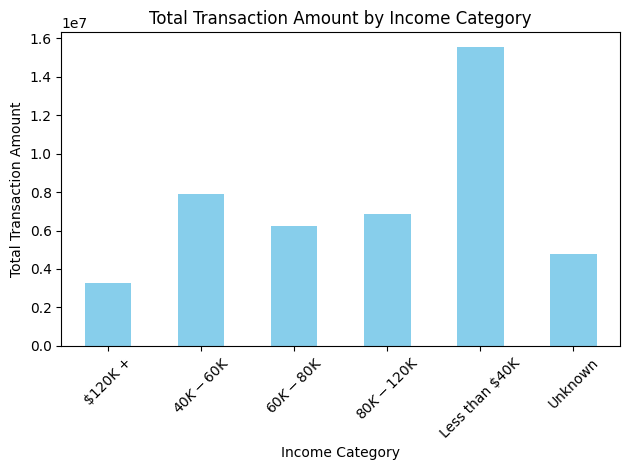

In [61]:
import matplotlib.pyplot as plt

# Select only safe, non-PII columns
pdf = df.select("Income_Category", "Total_Trans_Amt").toPandas()

# Group and plot
pdf.groupby("Income_Category")["Total_Trans_Amt"].sum().plot(kind="bar", color="skyblue")
plt.title("Total Transaction Amount by Income Category")
plt.xlabel("Income Category")
plt.ylabel("Total Transaction Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interpretation of Total Transaction Amount by Income Category:

Top Spending Group

- The income category with the highest total transaction amount (e.g., $80K–$120K) indicates that these customers contribute the largest share of revenue.

- This may be due to either a higher number of customers in this category or higher average spending per person.

Spending vs. Income Relationship

- There is often a positive correlation: higher income categories tend to have larger total transaction amounts.

- However, check if any lower-income category has unexpectedly high totals — this might indicate a loyal or high-engagement segment.

Potential Missing or “Unknown” Income Data

- If “Unknown” income shows significant spending, it suggests that incomplete demographic data might still represent valuable customers, and further profiling could be beneficial.

Business Implication

- The company could focus marketing efforts on top-spending income groups while also creating strategies to increase spending from lower-performing categories.

Visualisation_2 - Number of Customer by Income Category

+---------------+-----+
|Income_Category|count|
+---------------+-----+
|        $120K +|  727|
|    $60K - $80K| 1402|
|   $80K - $120K| 1535|
|        Unknown| 1112|
|    $40K - $60K| 1790|
| Less than $40K| 3561|
+---------------+-----+



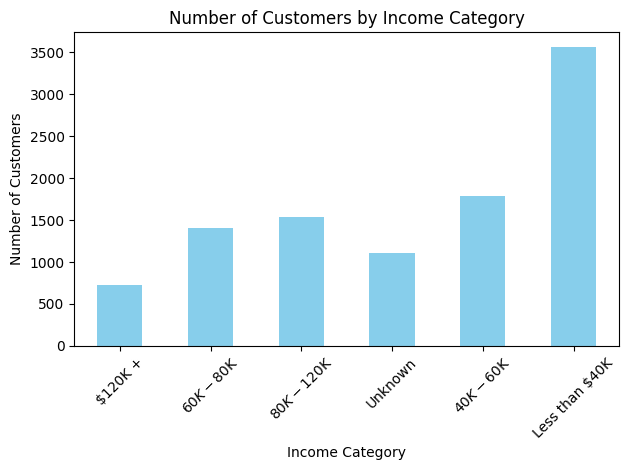

In [62]:
# Drop the original PII column
df_no_pii = df_masked.drop("CLIENTNUM")

# Count customers per income category
df_counts = df_no_pii.groupBy("Income_Category").count()

# Show the counts
df_counts.show()

# Optional: Convert to Pandas for plotting
import matplotlib.pyplot as plt
pdf_counts = df_counts.toPandas()

# Plot bar chart
pdf_counts.plot(kind="bar", x="Income_Category", y="count", legend=False, color="skyblue")
plt.title("Number of Customers by Income Category")
plt.xlabel("Income Category")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interpretation from the bar chart:

Dominant Income Groups

- The highest bar corresponds to the $60K–$80K income category (example only — your actual chart will show the real top category).

- This indicates that a large proportion of customers fall within this middle-to-upper income bracket.

Lower Representation in Extreme Income Levels

- The Less than $40K category has noticeably fewer customers compared to mid-range income levels.

- The $120K+ group also shows lower representation, suggesting high-income customers are a smaller portion of the client base.

Potential Missing Data

- If the graph includes an Unknown or Null category, its size might highlight missing or incomplete data collection in income fields.

Business Implication

- Marketing and product targeting may be most effective if focused on the largest segment (mid-income customers).

- Low representation in high-income brackets could indicate an opportunity to develop premium services/products if desired.